In [1]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, model_from_json

In [2]:
# load json and create model

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [3]:
# load weights into new model

loaded_model.load_weights("model.h5")

In [4]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

In [6]:
layer_dict = dict([(layer.name, layer) for layer in loaded_model.layers])

In [7]:
layer_dict

{'batch_normalization': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f78bc0a7e48>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f78bc014588>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78c26e8fd0>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78c270c4a8>,
 'conv2d_10': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bbfe8b00>,
 'conv2d_11': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bbff1b70>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78c270ca58>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bc06d1d0>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bc00d518>,
 'conv2d_5': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bbfc1470>,
 'conv2d_6': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f78bbfc7080>,


In [10]:
def visualise_filter(layer_name, filter_index):
  # layer_name = 'conv2d_1'
  # filter_index = 0 # Which filter in this block would you like to visualise?

  # Grab the filters and biases for that layer
  filters, biases = layer_dict[layer_name].get_weights()

  # Normalize filter values to a range of 0 to 1 so we can visualize them
  f_min, f_max = np.amin(filters), np.amax(filters)
  filters = (filters - f_min) / (f_max - f_min)

  # Plot first few filters
  n_filters, index = 6, 1
  for i in range(n_filters):
      f = filters[:, :, :, i]
      
      # Plot each channel separately
      for j in range(3):

          ax = plt.subplot(n_filters, 3, index)
          ax.set_xticks([])
          ax.set_yticks([])
          
          plt.imshow(f[:, :, j], cmap='viridis')
          index += 1
          
  plt.show()

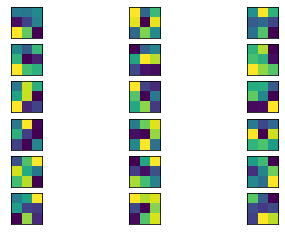

In [14]:
visualise_filters('conv2d_10', 10)

In [42]:
def visualise_features(img_path):
  successive_outputs = [layer.output for layer in loaded_model.layers[1:]][:15]
  visualization_model = tf.keras.models.Model(inputs = loaded_model.input, outputs = successive_outputs)

  #Load the input image
  img = load_img(img_path, target_size=(256, 256))

  x   = img_to_array(img)                           
  x   = x.reshape((1,) + x.shape)
  x /= 255.0

  x = rgb2lab(1.0/255*x)[:,:,:,0]
  x = x.reshape(x.shape+(1,))

  # Obtain all intermediate representations for the image.
  successive_feature_maps = visualization_model.predict(x)

  # Retrieve the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in loaded_model.layers]
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(layer_name, feature_map.shape)
    if len(feature_map.shape) == 4:
      
      # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
      
      # Postprocess the feature to be visually palatable
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
  # Display the grid
      scale = 30. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )

(1, 128, 128, 64)
(1, 128, 128, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 32, 32, 128)
(1, 32, 32, 256)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 32, 32, 256)
(1, 16, 16, 256)
(1, 16, 16, 512)
(1, 32, 32, 512)
(1, 32, 32, 256)


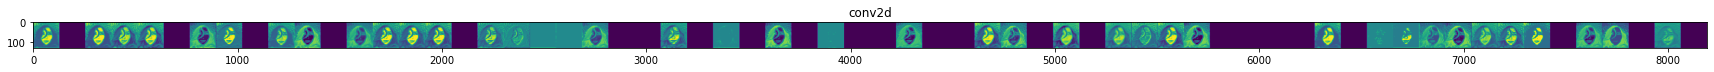

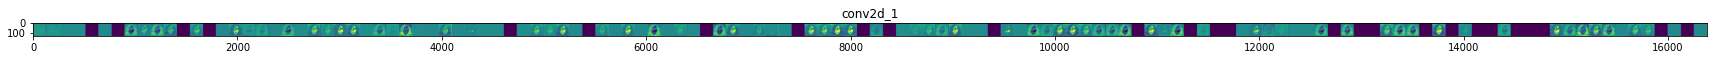

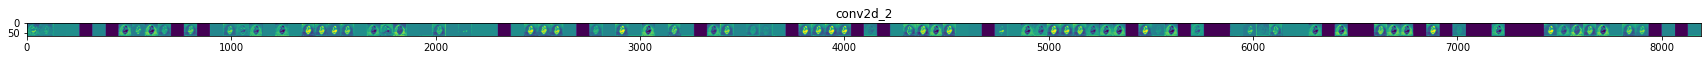

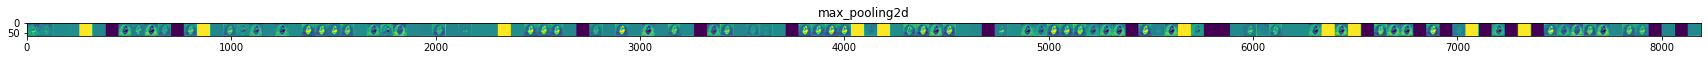

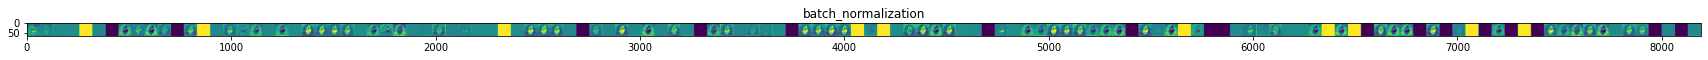

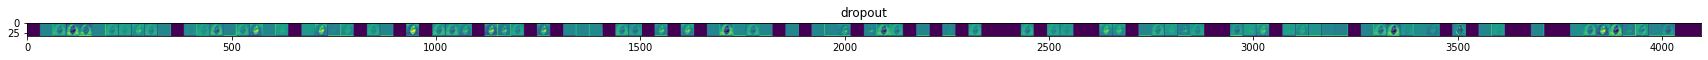

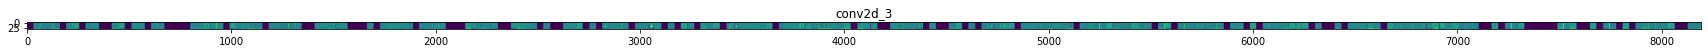

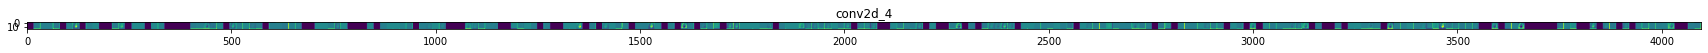

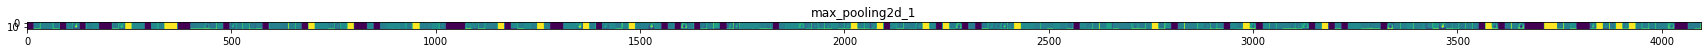

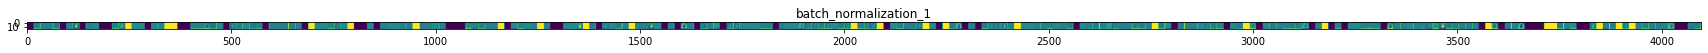

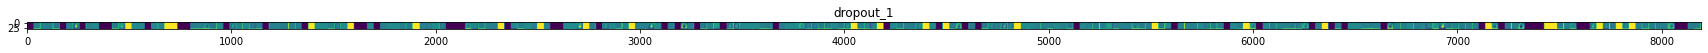

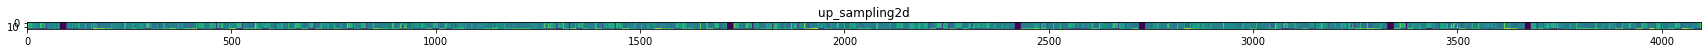

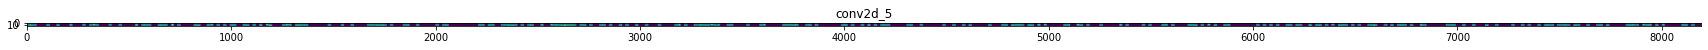

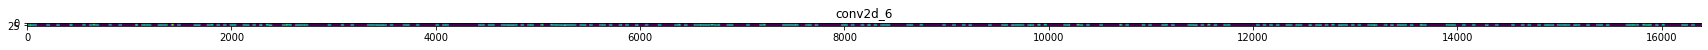

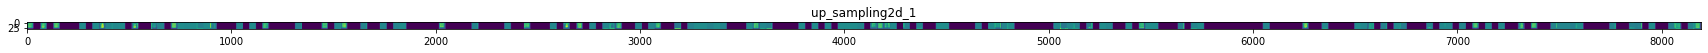

In [39]:
visualise_features('27gIpN.jpg')

conv2d (1, 128, 128, 64)
conv2d_1 (1, 128, 128, 128)
conv2d_2 (1, 64, 64, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


max_pooling2d (1, 64, 64, 128)
batch_normalization (1, 64, 64, 128)
dropout (1, 32, 32, 128)
conv2d_3 (1, 32, 32, 256)
conv2d_4 (1, 16, 16, 256)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


max_pooling2d_1 (1, 16, 16, 256)
batch_normalization_1 (1, 16, 16, 256)
dropout_1 (1, 32, 32, 256)
up_sampling2d (1, 16, 16, 256)
conv2d_5 (1, 16, 16, 512)
conv2d_6 (1, 32, 32, 512)
up_sampling2d_1 (1, 32, 32, 256)


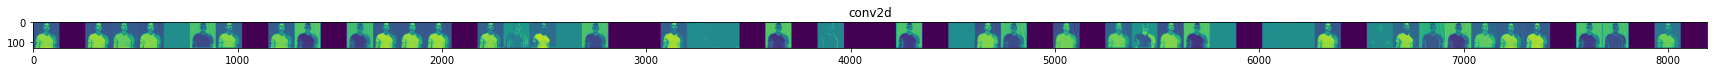

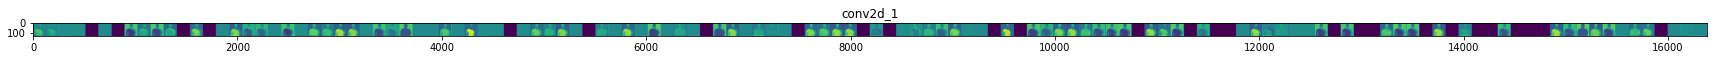

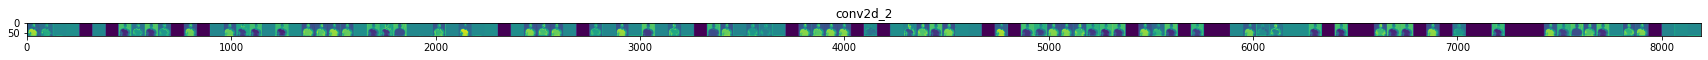

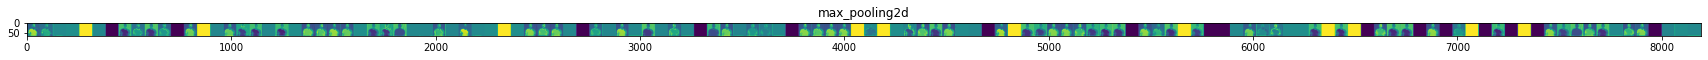

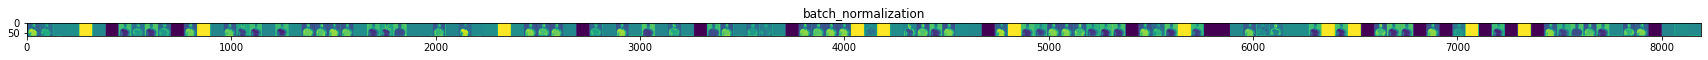

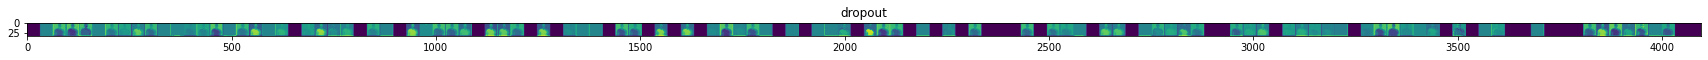

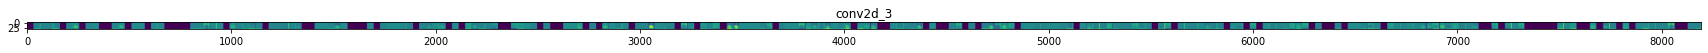

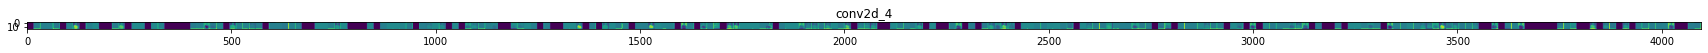

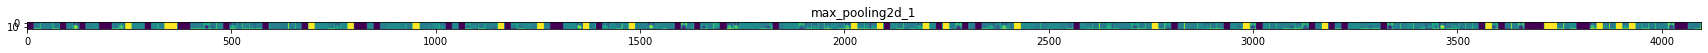

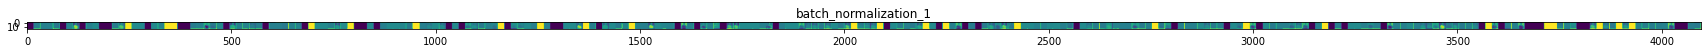

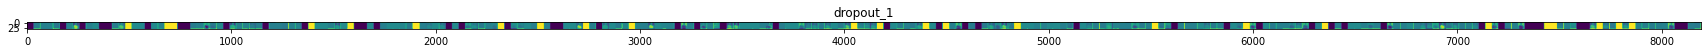

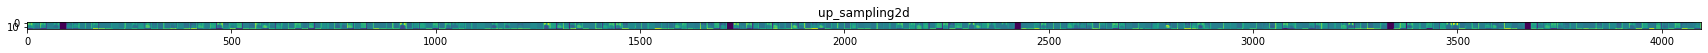

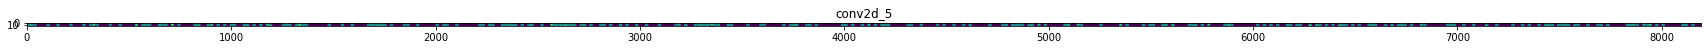

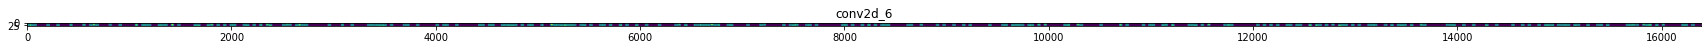

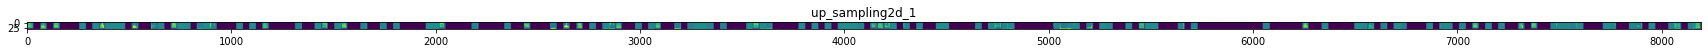

In [43]:
visualise_features('9k23H-ghsIY.jpg')